# Data Pipeline

## 0. Load Required Libraries

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
import joblib
import os
import yaml
import src.util as util
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from datetime import date
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates


## 1. Load Configuration File

In [2]:
def read_raw_data(config: dict) -> pd.DataFrame:
    # Load and define stock ticker list at IDX
    #stock_list = pd.read_excel(config['raw_dataset_dir'])
    target_stock = config['target_stock']
    feature_stocks = config['feature_stock']

    # Add new column with a value suitable to ticker name at yfinance
    #stock_list['ticker.jk'] = stock_list['Kode'] + config['ticker_ext']

    # Take only the needed column and change it from df to list
    #ticker_list = stock_list['ticker.jk'].tolist()
    
    # Define the date range parameter
    start_date = config['start_date']
    end_date = date.today()
    interval = config['interval_date']

    # Download stock data from yfinance
    target_data = yf.download(target_stock, start=start_date, end=end_date, interval=interval)["Adj Close"]
    feature_data = yf.download(feature_stocks, start=start_date, end=end_date, interval=interval)["Adj Close"]

    # Convert the Series to a DataFrame
    target_data = target_data.reset_index()
    target_data.columns = ['Date', config['target_stock']]
    target_data.set_index('Date', inplace=True)
    
    # return raw dataset
    return target_data, feature_data

In [3]:
def calculate_log_returns(data):
    log_returns = np.log(data) - np.log(data.shift(1))
    return log_returns

In [4]:
config_data = util.load_config()
target_data, feature_data = read_raw_data(config_data)
display(target_data)
display(feature_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  3 of 3 completed


,BMRI.JK
Date,
2022-01-03,3201.196533
2022-01-04,3257.955322
2022-01-05,3189.844727
2022-01-06,3189.844727
2022-01-07,3201.196533
...,...
2023-04-26,5200.000000
2023-04-27,5200.000000
2023-04-28,5175.000000


,^JKII,^JKLQ45,^JKSE
Date,,,
2022-01-03,569.419983,943.320007,6665.308105
2022-01-04,572.349976,947.880005,6695.373047
2022-01-05,565.580017,939.299988,6662.298828
2022-01-06,566.520020,940.500000,6653.351074
2022-01-07,572.869995,949.859985,6701.315918
...,...,...,...
2023-04-26,578.690002,963.210022,6910.146973
2023-04-27,577.200012,965.080017,6945.477051
2023-04-28,577.280029,961.750000,6915.715820


In [5]:
raw_dataset = pd.concat([target_data, feature_data], axis=1)
raw_dataset['BMRI.JK'].loc['2023-03-30'] = float(5112)



In [6]:
# Save raw dataset & log data to file
util.pickle_dump(raw_dataset, config_data['raw_dataset_path'])

In [7]:
log_data = calculate_log_returns(raw_dataset)
log_data.dropna(inplace=True )

log_data

,BMRI.JK,^JKII,^JKLQ45,^JKSE
Date,,,,
2022-01-04,0.017575,0.005132,0.004822,0.004501
2022-01-05,-0.021128,-0.011899,-0.009093,-0.004952
2022-01-06,0.000000,0.001661,0.001277,-0.001344
2022-01-07,0.003552,0.011146,0.009903,0.007183
2022-01-10,0.000000,-0.010247,-0.005998,-0.001522
...,...,...,...,...
2023-04-26,0.004819,0.016201,0.015558,0.012866
2023-04-27,0.000000,-0.002578,0.001940,0.005100
2023-04-28,-0.004819,0.000139,-0.003456,-0.004294


In [8]:
# Check nan value
log_data.isna().any().sum()

0

In [9]:
# Save raw dataset & log data to file
util.pickle_dump(log_data, config_data['log_dataset_path'])

## 2. Data Definition

## 3. Data Validation

### 3.1 Data type

In [10]:
# Chek data type each variable
log_data.dtypes

BMRI.JK    float64
^JKII      float64
^JKLQ45    float64
^JKSE      float64
dtype: object

In [11]:
# since there are a lot of columns, need to check the dtypes in summarry
# showing that there are only 2 dtypes, datetime & float.
log_data.dtypes.value_counts()

float64    4
dtype: int64

### 3.2 Data Range

In [12]:
log_data.describe()

,BMRI.JK,^JKII,^JKLQ45,^JKSE
count,323.000000,323.000000,323.000000,323.000000
mean,0.001517,-0.000053,0.000014,0.000068
std,0.017231,0.008799,0.009235,0.007922
min,-0.072391,-0.041044,-0.056366,-0.045155
25%,-0.007050,-0.005620,-0.006150,-0.004617
50%,0.000000,-0.000208,0.000503,0.000176
75%,0.010068,0.005813,0.006105,0.005216
max,0.084475,0.025602,0.025833,0.022169


In [13]:
# Check data statistics, since the column qty is a lot, then we summarize the describe feature in following function
def raw_dataset_describe(dataset):

    # Get the date index statistic info
    date_df = pd.Series(dataset.index).describe(include='datetime64', datetime_is_numeric=True)

    df = dataset.describe()
    # Get the minimum value for each row across all columns and convert it to a DataFrame
    row_min_df = df.min(axis=1).to_frame('Min')

    # Get the maximum value for each row across all columns and convert it to a DataFrame
    row_max_df = df.max(axis=1).to_frame('Max')

    # Concatenate the min and max DataFrames horizontally
    result_df = pd.concat([date_df, row_min_df, row_max_df], axis=1)


    return result_df

In [14]:
# Call Dataset statistics
raw_dataset_describe(log_data)

,Date,Min,Max
count,323,323.000000,323.000000
mean,2022-09-01 15:27:18.390092800,-0.000053,0.001517
min,2022-01-04 00:00:00,-0.072391,-0.041044
25%,2022-05-10 12:00:00,-0.007050,-0.004617
50%,2022-09-06 00:00:00,-0.000208,0.000503
75%,2022-12-27 12:00:00,0.005216,0.010068
max,2023-05-03 00:00:00,0.022169,0.084475
std,NaN,0.007922,0.017231


### 3.3 Data Dimension

In [15]:
log_data.shape

(323, 4)

## 4. Data Defense

In [16]:
def check_data(input_data, params, print_errors=True):

    error_messages = []
    error_stock_tickers = []
    #input_data = input_data.fillna(0)
    try:
        # Check index data types
        assert input_data.index.dtype == params['datetime_index'], 'an error occurs in index format, should be datetime.'

        # Check index data type & range
        for column in input_data.columns:
            if input_data[column].dtype != 'float64':
                error_messages.append(f"Column ({column}) has a non-float data type")
                error_stock_tickers.append(column)


        if error_messages:
            total_errors = len(error_messages)
            error_summary = f"\nTotal errors: {total_errors} errors out of {len(input_data.columns)}\n"
            raise AssertionError(error_summary + "\n".join(error_messages))
    
    except AssertionError as e:
        if print_errors:
            print(e)
    
    return error_stock_tickers



In [17]:
# Check the error stock in the dataset
check_data(log_data, config_data)

[]

In [18]:
# Found error in stock above (SCPI.JK), which after checking through news and yfinance data,
# it is already delisted since 2013. So this stock should be removed since it is considered
# as an anomaly.
error_stock_tickers = check_data(log_data, config_data, print_errors=False)
log_data.drop(error_stock_tickers, axis=1, inplace=True)

In [19]:
# Recheck the data and found no issue
check_data(log_data, config_data)


[]

In [20]:
util.pickle_dump(raw_dataset, config_data["clean_dataset_path"])


## 5. Stationary Check

In [21]:
"""
#since for time series modelling we need the data to be stationary. 
#we check the statinary of our dataset.



# Define a function to perform the Augmented Dickey-Fuller test
def perform_adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    print("\n")

for column in log_data.columns:
    print(f"Column: {column}")
    
    fig, ax = plt.subplots()
    ax.plot(log_data[column])
    
    # Format the date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show a tick for every 6 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Display the year and month
    fig.autofmt_xdate()  # Rotate and align the date labels
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Time Series - {column}')
    plt.show()

    print("Summary Statistics:")
    split = round(len(log_data) / 2)
    X1, X2 = log_data[column][0:split], log_data[column][split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print(f"Mean: {mean1} vs {mean2}\nVariance: {var1} vs {var2}\n")

    print("Augmented Dickey-Fuller Test:")
    perform_adf_test(log_data[column])
"""

'\n#since for time series modelling we need the data to be stationary. \n#we check the statinary of our dataset.\n\n\n\n# Define a function to perform the Augmented Dickey-Fuller test\ndef perform_adf_test(series):\n    result = adfuller(series)\n    print(f"ADF Statistic: {result[0]}")\n    print(f"p-value: {result[1]}")\n    print("Critical Values:")\n    for key, value in result[4].items():\n        print(f"\t{key}: {value}")\n    print("\n")\n\nfor column in log_data.columns:\n    print(f"Column: {column}")\n    \n    fig, ax = plt.subplots()\n    ax.plot(log_data[column])\n    \n    # Format the date axis\n    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show a tick for every 6 months\n    ax.xaxis.set_major_formatter(mdates.DateFormatter(\'%m-%Y\'))  # Display the year and month\n    fig.autofmt_xdate()  # Rotate and align the date labels\n    \n    plt.xlabel(\'Date\')\n    plt.ylabel(\'Value\')\n    plt.title(f\'Time Series - {column}\')\n    plt.show()\n\n   

Column: BMRI.JK
Column: ^JKII
Column: ^JKLQ45
Column: ^JKSE


/var/folders/fy/zhbysd194v9gxlrksl8f4bp80000gn/T/ipykernel_64176/1011704646.py:49: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


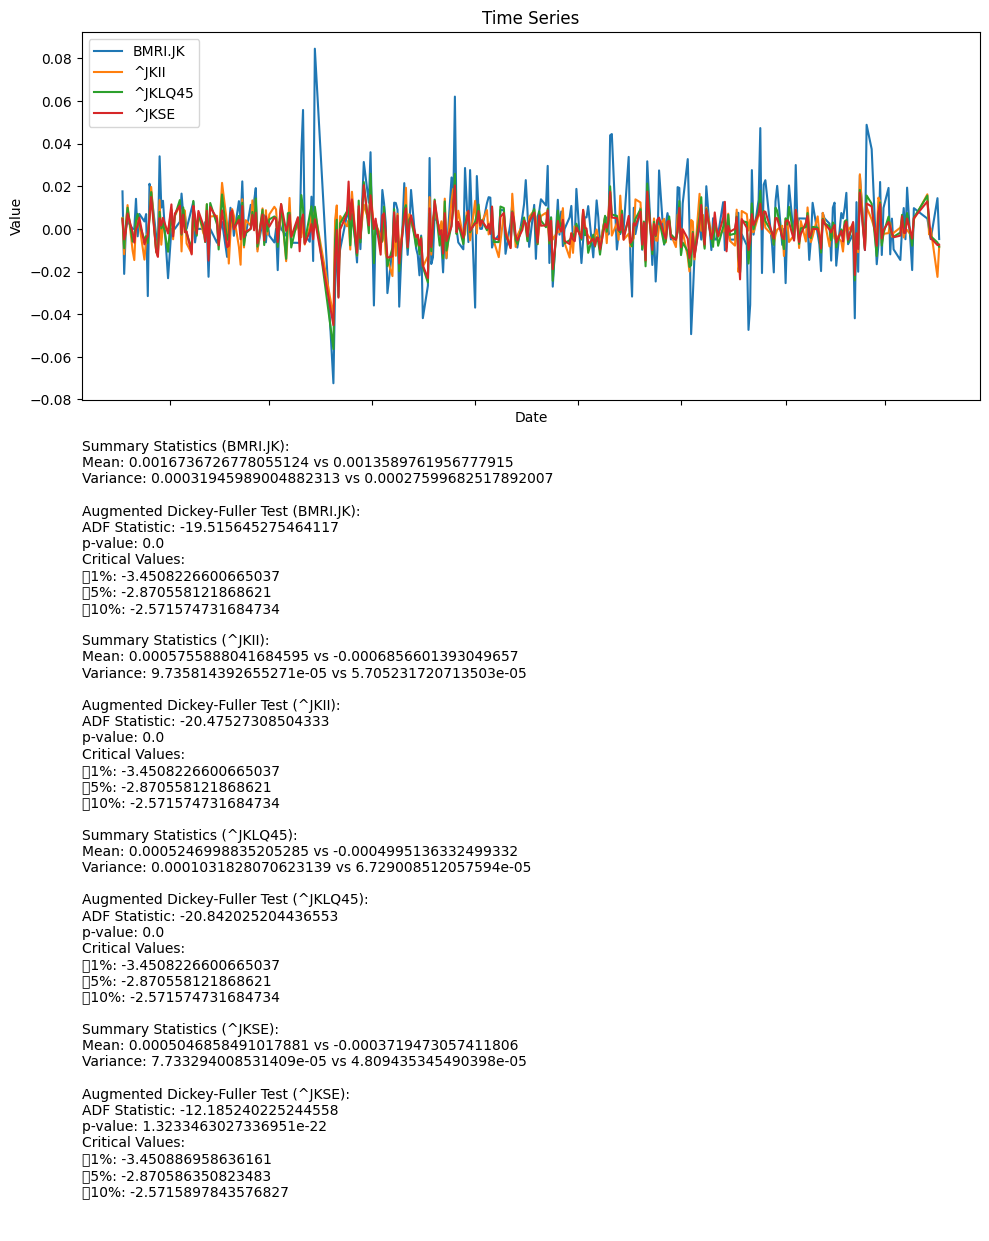

In [22]:
# Define a function to perform the Augmented Dickey-Fuller test
def perform_adf_test(series):
    result = adfuller(series)
    adf_output = f"ADF Statistic: {result[0]}\np-value: {result[1]}\nCritical Values:"
    for key, value in result[4].items():
        adf_output += f"\n\t{key}: {value}"
    return adf_output

# Create a figure with two subplots (one for the plot and one for the text)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), gridspec_kw={'height_ratios': [3, 2]})

# Initialize the text string
text_str = ""

# Iterate through each column and plot the time series
for column in log_data.columns:
    print(f"Column: {column}")
    ax1.plot(log_data[column], label=column)
    
    # Format the date axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show a tick for every 2 months
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Display the year and month
    fig.autofmt_xdate()  # Rotate and align the date labels
    
    ax1.set(xlabel='Date', ylabel='Value', title=f'Time Series')

    split = round(len(log_data) / 2)
    X1, X2 = log_data[column][0:split], log_data[column][split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    
    summary_stats = f"Summary Statistics ({column}):"
    summary_stats += f"\nMean: {mean1} vs {mean2}\nVariance: {var1} vs {var2}"
    
    adf_test_results = f"\n\nAugmented Dickey-Fuller Test ({column}):"
    adf_test_results += f"\n{perform_adf_test(log_data[column])}\n"
    
    # Update the text string with summary stats and ADF test results
    text_str += summary_stats + adf_test_results + "\n"

# Add legend to the plot
ax1.legend()

# Add the text string to the lower subplot
ax2.axis('off')
ax2.text(0, 1, text_str, transform=ax2.transAxes, fontsize=10, va='top')

# Display the figure with the plot and the text
plt.tight_layout()
plt.show()


#### Summary Statistics:

- The differences in mean and variance between the two halves are relatively small, which might suggest that the time series could be stationary. However, this is not a definitive conclusion, and we need to rely on the results of the Augmented Dickey-Fuller test for a more accurate determination.

- we divided the data into two halves to compute summary statistics simply as a quick way to examine if there are significant differences in mean and variance between two different time periods within the time series. This method is not as robust as the Augmented Dickey-Fuller test, but it can give a rough idea about the stationarity of the time series.

#### Augmented Dickey Fuller Test:
- In this case, the ADF statistic is less than the critical values at all significance levels (1%, 5%, 10%). The p-value is also less than a commonly used significance level of 0.05. Based on these results, we can reject the null hypothesis and conclude that the time series is stationary.

- 1% significance level: This is a stringent level that indicates a 1% risk of rejecting the null hypothesis when it is actually true. In other words, there's a 99% confidence level that the decision to reject the null hypothesis is correct.
- 5% significance level: This is a commonly used level that represents a 5% risk of rejecting the null hypothesis when it is true. This means there's a 95% confidence level that the decision to reject the null hypothesis is correct.
- 10% significance level: This level is less strict, with a 10% risk of rejecting the null hypothesis when it is true. In this case, there's a 90% confidence level that the decision to reject the null hypothesis is correct.

- By providing critical values for each of these significance levels, the ADF test allows you to decide which level of confidence is appropriate for your specific analysis. A lower significance level (e.g., 1%) requires stronger evidence against the null hypothesis than a higher significance level (e.g., 10%).

##### In summary, both the summary statistics and the Augmented Dickey-Fuller test suggest that the time series is stationary.

In [23]:
#adjust the lagging:
#log_data.iloc[:,1:] = log_data.iloc[:,1:].shift(1)
#log_data.dropna(inplace=True)  

In [24]:
util.pickle_dump(log_data, config_data["clean_dataset_path"])


## 5. Data Splitting

### 5.1 Time Series Split

In [25]:
def split_data(data, train_ratio, validation_ratio, params):
    train_size = int(len(data)*train_ratio)
    val_size = int(len(data)*validation_ratio)

    train_data = data[:train_size]
    val_data = data[train_size : train_size+val_size]
    test_data = data[train_size + val_size:]

    # Split feature and target columns for train, test, and validation sets
    feature_columns = data.drop([params['target_stock']], axis=1).columns
    target_column = params['target_stock']
    X_train, y_train = train_data[feature_columns], train_data[target_column]
    X_val, y_val = val_data[feature_columns], val_data[target_column]
    X_test, y_test = test_data[feature_columns], test_data[target_column]

    return X_train, y_train, X_val, y_val, X_test, y_test


In [26]:
# Split feature and target columns for train, test, and validation sets

X_train, y_train, X_val, y_val, X_test, y_test = split_data(data=log_data, train_ratio=0.8, validation_ratio=0.1, params=config_data)

print("TRAIN Set:")
display(X_train, display_id='X_train')
display(y_train, display_id='y_train')

print("VALIDATION Set:")
display(X_val, display_id='X_val')
display(y_val, display_id='y_val')

print("TEST Set:")
display(X_test, display_id='X_test')
display(y_test, display_id='y_test')





TRAIN Set:


,^JKII,^JKLQ45,^JKSE
Date,,,
2022-01-04,0.005132,0.004822,0.004501
2022-01-05,-0.011899,-0.009093,-0.004952
2022-01-06,0.001661,0.001277,-0.001344
2022-01-07,0.011146,0.009903,0.007183
2022-01-10,-0.010247,-0.005998,-0.001522
...,...,...,...
2023-01-12,-0.001208,0.011918,0.006884
2023-01-13,-0.001556,-0.000210,0.001793
2023-01-16,0.006449,0.008610,0.006936


Date
2022-01-04    0.017575
2022-01-05   -0.021128
2022-01-06    0.000000
2022-01-07    0.003552
2022-01-10    0.000000
                ...   
2023-01-12    0.027550
2023-01-13   -0.002721
2023-01-16    0.013532
2023-01-17    0.047253
2023-01-18   -0.020726
Name: BMRI.JK, Length: 258, dtype: float64

VALIDATION Set:


,^JKII,^JKLQ45,^JKSE
Date,,,
2023-01-19,0.006734,0.008408,0.007967
2023-01-20,0.000541,0.003620,0.008036
2023-01-24,-0.002944,-0.001766,-0.002050
2023-01-25,-0.007109,-0.007491,-0.004517
2023-01-26,-0.002700,0.009925,0.005095
2023-01-27,-0.000394,0.008555,0.004964
2023-01-30,0.001454,-0.004538,-0.003849
2023-01-31,-0.012697,-0.009501,-0.004834
2023-02-01,0.004474,0.004953,0.003345


Date
2023-01-19    0.020726
2023-01-20    0.022815
2023-01-24   -0.007547
2023-01-25   -0.020409
2023-01-26    0.012804
2023-01-27    0.020152
2023-01-30   -0.007509
2023-01-31    0.000000
2023-02-01   -0.025447
2023-02-02    0.002574
2023-02-03    0.020357
2023-02-06   -0.005050
2023-02-07    0.029927
2023-02-08    0.002454
2023-02-09    0.004890
2023-02-10    0.004866
2023-02-13    0.004843
2023-02-14    0.002413
2023-02-15   -0.014563
2023-02-16   -0.004902
2023-02-17    0.012210
2023-02-20   -0.002430
2023-02-21   -0.007326
2023-02-22   -0.019803
2023-02-23    0.007472
2023-02-24    0.004951
2023-02-27    0.002466
2023-02-28   -0.014889
2023-03-01    0.009950
2023-03-02    0.012300
2023-03-03   -0.017263
2023-03-06    0.007435
Name: BMRI.JK, dtype: float64

TEST Set:


,^JKII,^JKLQ45,^JKSE
Date,,,
2023-03-07,-0.010621,-0.003180,-0.005930
2023-03-08,-0.001455,0.003520,0.001420
2023-03-09,0.003298,0.004092,0.003451
2023-03-10,-0.000496,-0.006117,-0.005086
2023-03-13,0.002070,0.002877,0.003196
2023-03-14,-0.014869,-0.024188,-0.021617
2023-03-15,-0.009645,-0.003483,-0.002061
2023-03-16,-0.010928,-0.007345,-0.009460
2023-03-17,0.025602,0.018289,0.016991


Date
2023-03-07    0.004926
2023-03-08    0.009780
2023-03-09    0.016888
2023-03-10   -0.007203
2023-03-13   -0.002413
2023-03-14   -0.041930
2023-03-15    0.012516
2023-03-16   -0.020101
2023-03-17    0.025064
2023-03-20   -0.009950
2023-03-21    0.048790
2023-03-24    0.037387
2023-03-27   -0.016593
2023-03-28   -0.007380
2023-03-29    0.021979
2023-03-30   -0.012249
2023-03-31    0.009830
2023-04-03    0.019185
2023-04-04   -0.011948
2023-04-05    0.004796
2023-04-06   -0.009615
2023-04-10   -0.014599
2023-04-11    0.000000
2023-04-12    0.009756
2023-04-13   -0.004866
2023-04-14    0.019324
2023-04-17   -0.019324
2023-04-18    0.009709
2023-04-26    0.004819
2023-04-27    0.000000
2023-04-28   -0.004819
2023-05-02    0.014389
2023-05-03   -0.004773
Name: BMRI.JK, dtype: float64

<DisplayHandle display_id=y_test>

In [27]:
util.pickle_dump(X_train, config_data["train_set_path"][0])
util.pickle_dump(y_train, config_data["train_set_path"][1])

util.pickle_dump(X_val, config_data["valid_set_path"][0])
util.pickle_dump(y_val, config_data["valid_set_path"][1])

util.pickle_dump(X_test, config_data["test_set_path"][0])
util.pickle_dump(y_test, config_data["test_set_path"][1])